In [1]:
from astropy.io import fits
from astropy.table import Table
import numpy as np
import matplotlib.pylab as plt 
import matplotlib.lines as mlines
from matplotlib.legend import Legend
from pythonds.basic.stack import Stack
from math import *
from sklearn.neighbors import KDTree
from lrg_plot_functions import *
from lrg_sum_functions import *
from cosmo_Calc import *
from divideByTwo import *
from read_data import *
from nearNeighbors import *
from scipy import stats
from astropy import stats
import healpy as hp
from localBKG_and_interlopersHEALPix import *
# import healpy as hpy
from makeCutoutTableFunc import *
from plotHistogramProjections3D import *
from read_bricks import *
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [2]:
# Reads in data files for use in readData.py

hdu_sweep1 = fits.open('/Users/mtownsend/anaconda/Data/sweep-140p000-150p005-UVISTA1.fits') # this is one sweep file of the DECaLS data
hdu_sweep2 = fits.open('/Users/mtownsend/anaconda/Data/sweep-150p000-160p005-UVISTA2.fits') # this is one sweep file of the DECaLS data

UVISTA1_data = hdu_sweep1[1].data
UVISTA2_data = hdu_sweep2[1].data

ra_LS1, dec_LS1, gflux_LS1, rflux_LS1, zflux_LS1, w1flux_LS1, w2flux_LS1, w3flux_LS1, w4flux_LS1, gflux_ivar_LS1, rflux_ivar_LS1, zflux_ivar_LS1, w1flux_ivar_LS1, w2flux_ivar_LS1, w3flux_ivar_LS1, w4flux_ivar_LS1, mw_transmission_g_LS1, mw_transmission_r_LS1, mw_transmission_z_LS1, mw_transmission_w1_LS1, mw_transmission_w2_LS1, mw_transmission_w3_LS1, mw_transmission_w4_LS1 = readBricks(UVISTA1_data)
ra_LS2, dec_LS2, gflux_LS2, rflux_LS2, zflux_LS2, w1flux_LS2, w2flux_LS2, w3flux_LS2, w4flux_LS2, gflux_ivar_LS2, rflux_ivar_LS2, zflux_ivar_LS2, w1flux_ivar_LS2, w2flux_ivar_LS2, w3flux_ivar_LS2, w4flux_ivar_LS2, mw_transmission_g_LS2, mw_transmission_r_LS2, mw_transmission_z_LS2, mw_transmission_w1_LS2, mw_transmission_w2_LS2, mw_transmission_w3_LS2, mw_transmission_w4_LS2 = readBricks(UVISTA2_data)

print("end readdata")

# IMPORTANT NOTE: LRG data is the same for each.

done reading in DECaLS bricks
done reading in DECaLS bricks
end readdata


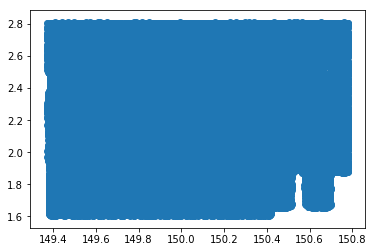

166641


In [3]:
# read in UV data

data_UV = open('/Users/mtownsend/eazy-photoz/inputs/OUTPUT/UVISTA_master_v4.1/UVISTA_final_v4.1.153-155.rf', 'r')
lines_UV = data_UV.readlines()[11:]

z = []
for line in lines_UV:
    p = line.split()
    z.append(float(p[1]))

z = np.array(z)

from astropy.io import ascii
data_cat = odata_cat = ascii.read("/Users/mtownsend/eazy-photoz/inputs/UVISTA_master_v4.1.cat")  

ra = data_cat['ra']
dec = data_cat['dec']
# z_spec = data_cat['z_spec']
use = data_cat['USE']
star = data_cat['star']
contamination = data_cat['contamination']
nan_contam = data_cat['nan_contam']
# z = data_cat['z_spec']

cut = np.where((use == 1.) & (star == 0.) & (contamination == 0.) & (nan_contam < 3.)) # & (Uflux > 0.) & (Vflux > 0.) & (zflux > 0.)) # & (zp > 0.))

ra_UV = ra[cut]
dec_UV = dec[cut]
z_peak = z[cut]

plt.scatter(ra_UV,dec_UV)
plt.show()

print(len(z_peak))


In [4]:
gmag_LS1 = 22.5 - 2.5 * np.log10(gflux_LS1/mw_transmission_g_LS1)
gmag_LS2 = 22.5 - 2.5 * np.log10(gflux_LS2/mw_transmission_g_LS2)
rmag_LS1 = 22.5 - 2.5 * np.log10(rflux_LS1/mw_transmission_r_LS1)
rmag_LS2 = 22.5 - 2.5 * np.log10(rflux_LS2/mw_transmission_r_LS2)
zmag_LS1 = 22.5 - 2.5 * np.log10(zflux_LS1/mw_transmission_z_LS1)
zmag_LS2 = 22.5 - 2.5 * np.log10(zflux_LS2/mw_transmission_z_LS2)

ra_LS = np.concatenate([ra_LS1, ra_LS2])
dec_LS = np.concatenate([dec_LS1, dec_LS2])
gmag_LS = np.concatenate([gmag_LS1, gmag_LS2])
rmag_LS = np.concatenate([rmag_LS1, rmag_LS2])
zmag_LS = np.concatenate([zmag_LS1, zmag_LS2]) 


# match sources in UVista and LS catalogs

from astropy.coordinates import SkyCoord, match_coordinates_sky                                   
from astropy import units as u       

UVISTA_cat  = SkyCoord(ra=ra_UV*u.degree, dec=dec_UV*u.degree)

my_cat = SkyCoord(ra=ra_LS*u.degree, dec=dec_LS*u.degree) 

idx_UVISTA, sep2d_UVISTA, dist3d_UVISTA = match_coordinates_sky(UVISTA_cat, my_cat, nthneighbor=1)

sep2d_UVISTA_deg = sep2d_UVISTA.deg

sep_idx_UVISTA = idx_UVISTA[np.where(sep2d_UVISTA_deg <= 0.0003)]

print(len(sep_idx_UVISTA))

69987


/Users/mtownsend/anaconda/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in log10


69987
69987


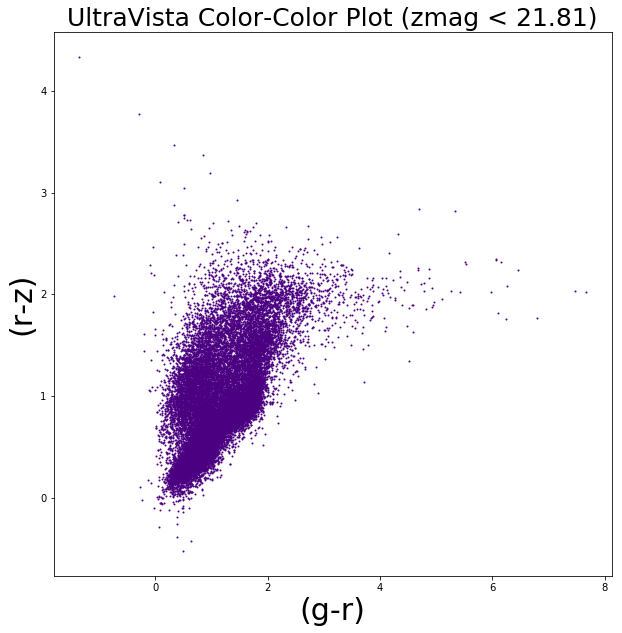

In [5]:
# calculate rest frame g-band luminosity

data_UV = open('/Users/mtownsend/eazy-photoz/inputs/OUTPUT/UV_LS_OUTPUT/UV_LS_main_output.294.rf', 'r')
lines_UV = data_UV.readlines()[10:]

distmod = []
gflux = []
redshift = []
for line in lines_UV:
    p = line.split()
    redshift.append(float(p[1]))
    distmod.append(float(p[2]))
    gflux.append(float(p[5]))

DM = np.array(distmod)
Gflux = np.array(gflux)
zspec = np.array(redshift)

# K correction
K_correct = -2.5*np.log10((1. + zspec)**-1.)

# Absolute magnitude
gMag = -2.5*np.log10(Gflux) + 25. - DM - K_correct

# Calculate rest frame zmag

Msun_z = 4.50
Msun_g = 5.05
gLum = 10.**((gMag-Msun_g)/(-2.5))

log_gLum = np.log10(gLum)

print(len(log_gLum))
print(len(zspec))

# calculate (g-r) and (r-z) colors
    
grcolor_UVLS_nocut = gmag_LS[sep_idx_UVISTA] - rmag_LS[sep_idx_UVISTA]
rzcolor_UVLS_nocut = rmag_LS[sep_idx_UVISTA] - zmag_LS[sep_idx_UVISTA]
zmag_UVLS_nocut = zmag_LS[sep_idx_UVISTA]

grcolor_UVLS = grcolor_UVLS_nocut[np.where((zmag_UVLS_nocut <= 22.36) & (np.isnan(log_gLum) == False))]
rzcolor_UVLS = rzcolor_UVLS_nocut[np.where((zmag_UVLS_nocut <= 22.36) & (np.isnan(log_gLum) == False))]
zmag_UVLS = zmag_UVLS_nocut[np.where((zmag_UVLS_nocut <= 22.36) & (np.isnan(log_gLum) == False))]

zspec_UVLS = zspec[np.where((zmag_UVLS_nocut <= 22.36) & (np.isnan(log_gLum) == False))]

log_gLum_cut = log_gLum[np.where((zmag_UVLS_nocut <= 22.36) & (np.isnan(log_gLum) == False))]


plt.rcParams["figure.figsize"] = [10, 10]
# plt.scatter(zmag_UVLS, rzcolor_UVLS, s=1, c='red', marker='*')
plt.scatter(grcolor_UVLS[np.where(zmag_UVLS < 21.81)], rzcolor_UVLS[np.where(zmag_UVLS < 21.81)], s=1, c='indigo')
# plt.scatter(zmag_UVLS[np.where((zmag_UVLS < 21.81) & (zspec_UVLS > 0.55) & (zspec_UVLS < 0.65))], rzcolor_UVLS[np.where((zmag_UVLS < 21.81) & (zspec_UVLS > 0.55) & (zspec_UVLS < 0.65))], s=1, c='green', marker='o')
plt.title('UltraVista Color-Color Plot (zmag < 21.81)', fontsize=25)
plt.xlabel('(g-r)', fontsize=30)
plt.ylabel('(r-z)', fontsize=30)
# plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/25June2020/UVcmd-zmagONLY.pdf')
# plt.tick_params(axis='both', which='major', labelsize=25)
plt.show()


In [15]:


# def making_masks(H1, lum_limit, x, y, z, lum, xedges, yedges, zedges):
def making_masks(H2D, H3D, lum_limit, x, y, z, lum, xedges, yedges, zedges):
    
    # lum_limit == luminosity threshold
    # x,y,z == arrays involved in the 3D histogram
    # lum = log luminosity array; same size as x (or y or z)
    # xedges,yedges,zedges = boundaries to search for x,y,z
    
    import numpy as np
    
    temp = []
#     medzmag = np.zeros_like(H2D, dtype=float)
    medzmag = np.full_like(H2D, -999., dtype=float)
#     indexlist = np.zeros((2,2,2),dtype=list)

    # This loop finds the observed zmag that cooresponds to the luminosity limit for each cell in color-color space
    for i in range(len(xedges)-1):
        for j in range(len(yedges)-1):
            for m in range(len(x)):
                if ((x[m] >= xedges[i]) & (x[m] <= xedges[i+1]) & (y[m] >= yedges[j]) & (y[m] <= yedges[j+1])):
#                     print('index: ', m)
#                     print('luminosity: ', lum[m])
#                     print('zmag: ', z[m])
#                     print("---")
                    if (abs(lum[m]-lum_limit) < 0.2):
                        temp.append(z[m])
#                         print(temp)
#                         print(lum[m])
#                         print(z[m])
#                         print('----')
                    if (len(temp) > 0.):
#                         print('temp: ', temp)
                        medzmag[i][j] = np.median(list(temp))
#                         print(medzmag[i][j])
#                         print('median zmag: ', medzmag[i][j])
#                         print('----')
#                     else:
#                         medzmag[i][j] = -999.
#                 else:
#                     medzmag[i][j] = -999.
#         print('temp before: ', temp)
        temp = []
#         print('temp after: ', temp)       
#     median_zmag_array = medzmag
#     print(test_array)
#     print('----')
    
    mask_array = np.empty_like(H3D)
    
    # This loop finds the cells in color-color space that are brighter in the observed zmag than the median zmag
    # and makes a mask of 1s and 0s
    for i in range(len(mask_array)):
#         print(len(mask_array))
#     print(mask_array[i])
#     print(edges2[i+1])
#     print('----')
        for j in range(len(mask_array[i])):
            for k in range(len(mask_array[i][j])):
#                 if (median_zmag_array[i][j] >= zedges[k+1]):
                if ((medzmag[i][j] >= 21.02509002685544) & (21.02509002685544 >= zedges[k+1])):
                    mask_array[i][j][k] = 1
#                     print('i = ',i)
#                     print('j = ', j)
#                     print('k = ', k)
#                     print(mask_array[i][j][k])
#                     print('----')
                else:
                    mask_array[i][j][k] = 0
#                     print('i = ', i)
#                     print('j = ', j)
#                     print('k = ', k)
#                     print(mask_array[i][j][k])
#                     print('----')

    return medzmag, mask_array



In [ ]:
# rz_edges = [-1.8027077, -1.5527076721191406, -1.3027076721191406, -1.0527076721191406, -0.8027076721191406, -0.5527076721191406, -0.3027076721191406, -0.052707672119140625, 0.19729232788085938, 0.4472923278808594, 0.6972923278808594, 0.9472923278808594, 1.1972923278808594, 1.4472923278808594, 1.6972923278808594, 1.9472923278808594, 2.1972923278808594, 2.4472923278808594, 2.6972923278808594, 2.9472923278808594, 3.1972923278808594, 3.4472923278808594, 3.6972923278808594, 3.9472923278808594, 4.197292327880859, 4.447292327880859, 4.697292327880859, 4.947292327880859, 5.197292327880859, 5.447292327880859, 5.697292327880859, 5.947292327880859, 6.197292327880859, 6.447292327880859, 6.697292327880859, 6.947292327880859, 7.197292327880859, 7.447292327880859, 7.697292327880859, 7.947292327880859, 8.19729232788086, 8.44729232788086, 8.69729232788086, 8.94729232788086, 9.19729232788086, 9.44729232788086, 9.69729232788086, 9.94729232788086, 10.19729232788086, 10.44729232788086]
# zmag_edges = [13.22509, 13.425090026855468, 13.625090026855467, 13.825090026855467, 14.025090026855466, 14.225090026855465, 14.425090026855464, 14.625090026855464, 14.825090026855463, 15.025090026855462, 15.225090026855462, 15.425090026855461, 15.62509002685546, 15.82509002685546, 16.02509002685546, 16.225090026855458, 16.425090026855457, 16.625090026855457, 16.825090026855456, 17.025090026855455, 17.225090026855455, 17.425090026855454, 17.625090026855453, 17.825090026855452, 18.02509002685545, 18.22509002685545, 18.42509002685545, 18.62509002685545, 18.82509002685545, 19.025090026855448, 19.225090026855447, 19.425090026855447, 19.625090026855446, 19.825090026855445, 20.025090026855445, 20.225090026855444, 20.425090026855443, 20.625090026855442, 20.82509002685544, 21.02509002685544, 21.22509002685544, 21.42509002685544, 21.62509002685544, 21.825090026855438, 22.025090026855437, 22.225090026855437, 22.425090026855436, 22.625090026855435, 22.825090026855435, 23.025090026855434]
# gr_edges = [-6.5846786, -6.234678649902344, -5.8846786499023445, -5.534678649902345, -5.184678649902345, -4.8346786499023455, -4.484678649902346, -4.134678649902346, -3.784678649902346, -3.434678649902346, -3.084678649902346, -2.734678649902346, -2.384678649902346, -2.0346786499023457, -1.6846786499023456, -1.3346786499023455, -0.9846786499023455, -0.6346786499023456, -0.2846786499023456, 0.06532135009765438, 0.41532135009765436, 0.7653213500976543, 1.1153213500976542, 1.4653213500976543, 1.8153213500976544, 2.1653213500976545, 2.5153213500976546, 2.8653213500976547, 3.2153213500976547, 3.565321350097655, 3.915321350097655, 4.265321350097655, 4.615321350097655, 4.965321350097654, 5.315321350097654, 5.665321350097654, 6.015321350097653, 6.365321350097653, 6.7153213500976525, 7.065321350097652, 7.415321350097652, 7.7653213500976515, 8.115321350097652, 8.465321350097652, 8.815321350097651, 9.165321350097651, 9.51532135009765, 9.86532135009765, 10.21532135009765, 10.56532135009765]


rz_edges = np.array([-1.8027077, -1.5527076721191406, -1.3027076721191406, -1.0527076721191406, -0.8027076721191406, -0.5527076721191406, -0.3027076721191406, -0.052707672119140625, 0.19729232788085938, 0.4472923278808594, 0.6972923278808594, 0.9472923278808594, 1.1972923278808594, 1.4472923278808594, 1.6972923278808594, 1.9472923278808594, 2.1972923278808594, 2.4472923278808594, 2.6972923278808594, 2.9472923278808594, 3.1972923278808594, 3.4472923278808594, 3.6972923278808594, 3.9472923278808594, 4.197292327880859, 4.447292327880859, 4.697292327880859, 4.947292327880859, 5.197292327880859, 5.447292327880859, 5.697292327880859, 5.947292327880859, 6.197292327880859, 6.447292327880859, 6.697292327880859, 6.947292327880859, 7.197292327880859, 7.447292327880859, 7.697292327880859, 7.947292327880859, 8.19729232788086, 8.44729232788086, 8.69729232788086, 8.94729232788086, 9.19729232788086, 9.44729232788086, 9.69729232788086, 9.94729232788086, 10.19729232788086, 10.44729232788086])
zmag_edges = np.array([13.22509, 14.025090026855466, 15.025090026855462, 16.02509002685546, 17.025090026855455, 18.02509002685545, 19.025090026855448, 20.025090026855445, 21.02509002685544, 22.025090026855437, 23.025090026855434])
gr_edges = np.array([-6.5846786, -6.234678649902344, -5.8846786499023445, -5.534678649902345, -5.184678649902345, -4.8346786499023455, -4.484678649902346, -4.134678649902346, -3.784678649902346, -3.434678649902346, -3.084678649902346, -2.734678649902346, -2.384678649902346, -2.0346786499023457, -1.6846786499023456, -1.3346786499023455, -0.9846786499023455, -0.6346786499023456, -0.2846786499023456, 0.06532135009765438, 0.41532135009765436, 0.7653213500976543, 1.1153213500976542, 1.4653213500976543, 1.8153213500976544, 2.1653213500976545, 2.5153213500976546, 2.8653213500976547, 3.2153213500976547, 3.565321350097655, 3.915321350097655, 4.265321350097655, 4.615321350097655, 4.965321350097654, 5.315321350097654, 5.665321350097654, 6.015321350097653, 6.365321350097653, 6.7153213500976525, 7.065321350097652, 7.415321350097652, 7.7653213500976515, 8.115321350097652, 8.465321350097652, 8.815321350097651, 9.165321350097651, 9.51532135009765, 9.86532135009765, 10.21532135009765, 10.56532135009765])

H3D, nouse_edges = np.histogramdd((rzcolor_UVLS, grcolor_UVLS, zmag_UVLS), bins=(rz_edges, gr_edges, zmag_edges), density=False)

mask_array = np.empty_like(H3D)
print(mask_array.shape)
print(len(mask_array[0][0]))
    
# This loop finds the cells in color-color space that are brighter in the observed zmag than the median zmag
# and makes a mask of 1s and 0s
for i in range(len(mask_array)):
    for j in range(len(mask_array[i])):
        for k in range(len(mask_array[i][j])):
            if ((rz_edges[i] > 2.) & (rz_edges[i] < 6.) & (zmag_edges[k] >= zmag_edges[3]) & (zmag_edges[k] <= zmag_edges[5])):
                mask_array[i][j][k] = 1
            elif ((rz_edges[i] > 6.) & (zmag_edges[k] >= zmag_edges[3]) & (zmag_edges[k] <= zmag_edges[5])):
                mask_array[i][j][k]= 2
            else:
                mask_array[i][j][k] = 0

print(len(mask_array[np.where(mask_array != 0)]))
print(len(mask_array))
print(len(grcolor_UVLS[np.where((rzcolor_UVLS > 0.8) & (zmag_UVLS >= zmag_edges[3]) & (zmag_UVLS <= zmag_edges[5]))]))

# print(zmag_edges[40])
print(np.median(rzcolor_UVLS))


# mask_array = np.empty_like(H3D)

# for i in range(len(rz_edges)-1):
#     for j in range(len(gr_edges)-1):
#         for k in range(len(zmag_edges)-1):
#             if ((rz_edges[i] > 2.) & (rz_edges[i] < 6.) & (zmag_edges[k] >= zmag_edges[10]) & (zmag_edges[k] <= zmag_edges[16])):
#                 mask_array[i][j][k] = 1
#             elif ((rz_edges[i] > 6.) & (zmag_edges[k] >= zmag_edges[10]) & (zmag_edges[k] <= zmag_edges[16])):
#                 mask_array[i][j][k]= 2
#             else:
#                 mask_array[i][j][k] = 0
#             if ((rz_edges[i] > 2.) & (zmag_edges[k] >= zmag_edges[10]) & (zmag_edges[k] <= zmag_edges[16])):
#                 mask_array[i][j][k] = 1
#             else:
#                 mask_array[i][j][k] = 0
            
            
#             for m in range(len(rzcolor_UVLS)):
#                 if ((rzcolor_UVLS[m] >= rz_edges[i]) & (rzcolor_UVLS[m] <= rz_edges[i+1]) & (grcolor_UVLS[m] >= gr_edges[j]) & (grcolor_UVLS[m] <= gr_edges[j+1]) & (zmag[m] >= zmag_edges[k]) & (zmag[m] <= zmag_edges[k+1])):
#                     temp.append(lum[m])
#                     if (len(temp) > 0.):
#                         lumlist[i][j][k] = np.median(list(temp))
# #                       indexlist[i][j][k] = list(temp)
#                     else:
#                         lumlist[i][j][k] = 0.


In [16]:
# rz_edges = [-1.8027077, -1.5527076721191406, -1.3027076721191406, -1.0527076721191406, -0.8027076721191406, -0.5527076721191406, -0.3027076721191406, -0.052707672119140625, 0.19729232788085938, 0.4472923278808594, 0.6972923278808594, 0.9472923278808594, 1.1972923278808594, 1.4472923278808594, 1.6972923278808594, 1.9472923278808594, 2.1972923278808594, 2.4472923278808594, 2.6972923278808594, 2.9472923278808594, 3.1972923278808594, 3.4472923278808594, 3.6972923278808594, 3.9472923278808594, 4.197292327880859, 4.447292327880859, 4.697292327880859, 4.947292327880859, 5.197292327880859, 5.447292327880859, 5.697292327880859, 5.947292327880859, 6.197292327880859, 6.447292327880859, 6.697292327880859, 6.947292327880859, 7.197292327880859, 7.447292327880859, 7.697292327880859, 7.947292327880859, 8.19729232788086, 8.44729232788086, 8.69729232788086, 8.94729232788086, 9.19729232788086, 9.44729232788086, 9.69729232788086, 9.94729232788086, 10.19729232788086, 10.44729232788086]
# zmag_edges = [13.22509, 13.425090026855468, 13.625090026855467, 13.825090026855467, 14.025090026855466, 14.225090026855465, 14.425090026855464, 14.625090026855464, 14.825090026855463, 15.025090026855462, 15.225090026855462, 15.425090026855461, 15.62509002685546, 15.82509002685546, 16.02509002685546, 16.225090026855458, 16.425090026855457, 16.625090026855457, 16.825090026855456, 17.025090026855455, 17.225090026855455, 17.425090026855454, 17.625090026855453, 17.825090026855452, 18.02509002685545, 18.22509002685545, 18.42509002685545, 18.62509002685545, 18.82509002685545, 19.025090026855448, 19.225090026855447, 19.425090026855447, 19.625090026855446, 19.825090026855445, 20.025090026855445, 20.225090026855444, 20.425090026855443, 20.625090026855442, 20.82509002685544, 21.02509002685544, 21.22509002685544, 21.42509002685544, 21.62509002685544, 21.825090026855438, 22.025090026855437, 22.225090026855437, 22.425090026855436, 22.625090026855435, 22.825090026855435, 23.025090026855434]
# gr_edges = [-6.5846786, -6.234678649902344, -5.8846786499023445, -5.534678649902345, -5.184678649902345, -4.8346786499023455, -4.484678649902346, -4.134678649902346, -3.784678649902346, -3.434678649902346, -3.084678649902346, -2.734678649902346, -2.384678649902346, -2.0346786499023457, -1.6846786499023456, -1.3346786499023455, -0.9846786499023455, -0.6346786499023456, -0.2846786499023456, 0.06532135009765438, 0.41532135009765436, 0.7653213500976543, 1.1153213500976542, 1.4653213500976543, 1.8153213500976544, 2.1653213500976545, 2.5153213500976546, 2.8653213500976547, 3.2153213500976547, 3.565321350097655, 3.915321350097655, 4.265321350097655, 4.615321350097655, 4.965321350097654, 5.315321350097654, 5.665321350097654, 6.015321350097653, 6.365321350097653, 6.7153213500976525, 7.065321350097652, 7.415321350097652, 7.7653213500976515, 8.115321350097652, 8.465321350097652, 8.815321350097651, 9.165321350097651, 9.51532135009765, 9.86532135009765, 10.21532135009765, 10.56532135009765]

rz_edges = np.array([-1.8027077, -1.5527076721191406, -1.3027076721191406, -1.0527076721191406, -0.8027076721191406, -0.5527076721191406, -0.3027076721191406, -0.052707672119140625, 0.19729232788085938, 0.4472923278808594, 0.6972923278808594, 0.9472923278808594, 1.1972923278808594, 1.4472923278808594, 1.6972923278808594, 1.9472923278808594, 2.1972923278808594, 2.4472923278808594, 2.6972923278808594, 2.9472923278808594, 3.1972923278808594, 3.4472923278808594, 3.6972923278808594, 3.9472923278808594, 4.197292327880859, 4.447292327880859, 4.697292327880859, 4.947292327880859, 5.197292327880859, 5.447292327880859, 5.697292327880859, 5.947292327880859, 6.197292327880859, 6.447292327880859, 6.697292327880859, 6.947292327880859, 7.197292327880859, 7.447292327880859, 7.697292327880859, 7.947292327880859, 8.19729232788086, 8.44729232788086, 8.69729232788086, 8.94729232788086, 9.19729232788086, 9.44729232788086, 9.69729232788086, 9.94729232788086, 10.19729232788086, 10.44729232788086])
zmag_edges = np.array([13.22509, 14.025090026855466, 15.025090026855462, 16.02509002685546, 17.025090026855455, 18.02509002685545, 19.025090026855448, 20.025090026855445, 21.02509002685544, 22.025090026855437, 23.025090026855434])
gr_edges = np.array([-6.5846786, -6.234678649902344, -5.8846786499023445, -5.534678649902345, -5.184678649902345, -4.8346786499023455, -4.484678649902346, -4.134678649902346, -3.784678649902346, -3.434678649902346, -3.084678649902346, -2.734678649902346, -2.384678649902346, -2.0346786499023457, -1.6846786499023456, -1.3346786499023455, -0.9846786499023455, -0.6346786499023456, -0.2846786499023456, 0.06532135009765438, 0.41532135009765436, 0.7653213500976543, 1.1153213500976542, 1.4653213500976543, 1.8153213500976544, 2.1653213500976545, 2.5153213500976546, 2.8653213500976547, 3.2153213500976547, 3.565321350097655, 3.915321350097655, 4.265321350097655, 4.615321350097655, 4.965321350097654, 5.315321350097654, 5.665321350097654, 6.015321350097653, 6.365321350097653, 6.7153213500976525, 7.065321350097652, 7.415321350097652, 7.7653213500976515, 8.115321350097652, 8.465321350097652, 8.815321350097651, 9.165321350097651, 9.51532135009765, 9.86532135009765, 10.21532135009765, 10.56532135009765])

# rzcolor = rzcolor_UVLS[0:19]
# print(rzcolor)
# print('----')
# grcolor = grcolor_UVLS[0:19]
# print(grcolor)
# print('----')
# zmag = zmag_UVLS[0:19]
# print(zmag)
# print('----')
# lum = log_gLum_cut[0:19]
# print(lum)
# print('----')
# print()
# print()

Hstar3D, nouse_edges = np.histogramdd((rzcolor_UVLS, grcolor_UVLS, zmag_UVLS), bins=(rz_edges, gr_edges, zmag_edges), density=False)
Hstar2D, rz_nouse, gr_nouse = np.histogram2d(rzcolor_UVLS, grcolor_UVLS, bins=(rz_edges, gr_edges), density=False)

# print(Hstar3D.shape)
# print(len(Hstar3D))
# make_array = np.empty_like(Hstar3D)
# print(make_array.shape)
# print(len(make_array))

medzmag, mask_array = making_masks(Hstar2D, Hstar3D, 10.46, rzcolor_UVLS, grcolor_UVLS, zmag_UVLS, log_gLum_cut, rz_edges, gr_edges, zmag_edges) #, edges[2])


# zinit = 0.2
# zfin = 0.65
# zinterval = 0.05
# znum = (zfin-zinit)/zinterval
# zrange, zstep = np.linspace(0.2, 0.65, num=int(znum), retstep=True)
# print(zrange)
# print(zstep)

# masks = []
# median_zmag = []
# for i in range(len(zrange)-1):
#     x = rzcolor_UVLS[np.where((zspec_UVLS > zrange[i]) & (zspec_UVLS <= zrange[i+1]))]
#     y = grcolor_UVLS[np.where((zspec_UVLS > zrange[i]) & (zspec_UVLS <= zrange[i+1]))]
#     z = zmag_UVLS[np.where((zspec_UVLS > zrange[i]) & (zspec_UVLS <= zrange[i+1]))]
#     lum = log_gLum_cut[np.where((zspec_UVLS > zrange[i]) & (zspec_UVLS <= zrange[i+1]))]
#     median_zmag_array, mask_array = making_masks(Hstar2D, Hstar3D, 10.46, x, y, z, lum, rz_edges, gr_edges, zmag_edges)
#     median_zmag.append(median_zmag_array)
#     masks.append(mask_array)
#     print(i)
    

22.356285095214844
0.0
21.64342498779297


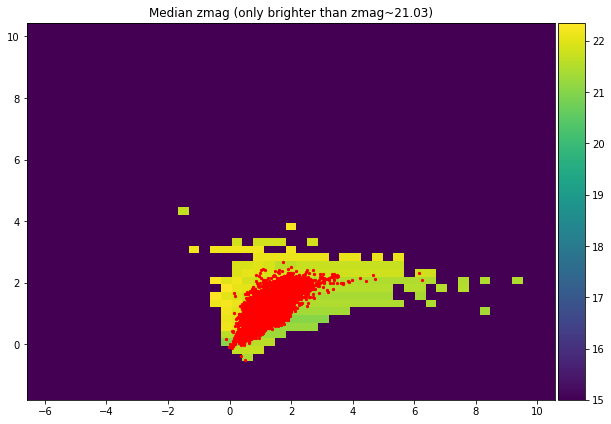

In [36]:
masked_H = mask_array * Hstar3D
projectionHstar = Hstar3D[:, :, :].sum(axis=2) 
projectionMask = mask_array[:, :, :].sum(axis=2)
projectionMasked_H = masked_H[:, :, :].sum(axis=2)

medzmag[medzmag == -999] = 0. 
# medzmag[medzmag > 21.02509002685544] = 0

print(medzmag.max())
print(medzmag.min())
print(np.median(medzmag[np.where(medzmag != 0.)]))

# print(len(grcolor_UVLS[np.where(zmag_UVLS <= 21.8)]))
# print(len(grcolor_UVLS[np.where(zmag_UVLS > 21.8)]))

# print(len(medzmag))
# print(np.median(medzmag[np.where(medzmag != 0)]))

# plt.figure(figsize=(10,10))
# ax = plt.gca()
# im = ax.imshow(projectionMask, vmax=21.03, origin='lower', extent=(gr_edges.min(), gr_edges.max(), rz_edges.min(), rz_edges.max()))
# # plt.scatter(grcolor_UVLS[np.where(zmag_UVLS > 21.02509002685544)], rzcolor_UVLS[np.where(zmag_UVLS > 21.02509002685544)], s=1, c='cyan')
# # plt.scatter(grcolor_UVLS[np.where(zmag_UVLS <= 21.02509002685544)], rzcolor_UVLS[np.where(zmag_UVLS <= 21.02509002685544)], alpha=1, s=5, c='red')
# divider = make_axes_locatable(ax)
# cax = divider.append_axes('right', size='5%', pad=0.05)
# plt.colorbar(im, cax=cax)
# ax.set_title("UV histogram for sources brighter than ")
# #     ax.set_ylim([-0.6,5.5])
# ax.set_xlabel('(g-r)',fontsize=20)
# ax.set_ylabel('(r-z)',fontsize=20)
# # plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/2July2020/e1-color-color-selection-matrix-21.03-overplot-21.03.pdf')   
# plt.show()


# plt.rcParams["figure.figsize"] = [10, 10]
# plt.scatter(zmag_UVLS, rzcolor_UVLS, s=1, c='red', marker='*')
# plt.scatter(grcolor_UVLS[np.where(zmag_UVLS < 21.81)], rzcolor_UVLS[np.where(zmag_UVLS < 21.81)], s=1, c='indigo')
# # plt.scatter(zmag_UVLS[np.where((zmag_UVLS < 21.81) & (zspec_UVLS > 0.55) & (zspec_UVLS < 0.65))], rzcolor_UVLS[np.where((zmag_UVLS < 21.81) & (zspec_UVLS > 0.55) & (zspec_UVLS < 0.65))], s=1, c='green', marker='o')
# plt.title('UltraVista Color-Color Plot (zmag < 21.81)', fontsize=25)
# plt.xlabel('(g-r)', fontsize=30)
# plt.ylabel('(r-z)', fontsize=30)
# # plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/25June2020/UVcmd-zmagONLY.pdf')
# # plt.tick_params(axis='both', which='major', labelsize=25)
# plt.show()


plt.figure(figsize=(10,10))
ax = plt.gca()
im = ax.imshow(medzmag, vmin=15., origin='lower', extent=(gr_edges.min(), gr_edges.max(), rz_edges.min(), rz_edges.max()))
plt.scatter(grcolor_UVLS[np.where(zmag_UVLS <= 21.02509002685544)], rzcolor_UVLS[np.where(zmag_UVLS <= 21.02509002685544)], alpha=1, s=5, c='red')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_title("Median zmag (only brighter than zmag~21.03)")
# ax.set_ylim([-1.,5.])
# ax.set_xlim([-1.,8.])
# ax.set_xlabel('zmag',fontsize=20)
# ax.set_ylabel('r-z',fontsize=20)
# plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/2July2020/b-medzmag-21.8.pdf')
plt.show()



In [ ]:
# rzcolor = rzcolor_UVLS[0:9]
# print(rzcolor)
# print('----')
# grcolor = grcolor_UVLS[0:9]
# print(grcolor)
# print('----')
# zmag = zmag_UVLS[0:9]
# print(zmag)
# print('----')
# lum = log_gLum_cut[0:9]
# print(lum)
# print('----')
# print()
# print()

# data = list(zip(rzcolor, grcolor, zmag))
# # print(data.shape)

# Htest3D, edges = np.histogramdd((rzcolor, grcolor, zmag), bins=(2,3,3), density=False)
# # Htest3D, edges = np.histogramdd(data.T, bins=(3,3,3), density=False)
# # Htest2D, rz_edges, gr_edges = np.histogram2d(rzcolor, grcolor, bins=(3,3), density=False)

# print(edges[0])
# print(edges[1])
# print(edges[2])

# print(Htest3D)
# print()
# print()
# print(Htest3D.shape)

# print(edges[0])
# print('zmag edges: ', edges[1])
# print(edges[2])
# print('---')
# print(rz_edges)
# print(gr_edges)


# medzmag, mask_array = making_masks(Htest2D, Htest3D, 10., rzcolor, grcolor, zmag, lum, rz_edges, gr_edges, edges[1]) #, edges[2])

# print(mask_array)
# print('----')
# print(medzmag)

# print(mask_array.shape)
# print(mask_array)
# print(mask_array[0][0])

# rz_edges = np.array([-1.8027077, -1.5527076721191406, -1.3027076721191406, -1.0527076721191406, -0.8027076721191406, -0.5527076721191406, -0.3027076721191406, -0.052707672119140625, 0.19729232788085938, 0.4472923278808594, 0.6972923278808594, 0.9472923278808594, 1.1972923278808594, 1.4472923278808594, 1.6972923278808594, 1.9472923278808594, 2.1972923278808594, 2.4472923278808594, 2.6972923278808594, 2.9472923278808594, 3.1972923278808594, 3.4472923278808594, 3.6972923278808594, 3.9472923278808594, 4.197292327880859, 4.447292327880859, 4.697292327880859, 4.947292327880859, 5.197292327880859, 5.447292327880859, 5.697292327880859, 5.947292327880859, 6.197292327880859, 6.447292327880859, 6.697292327880859, 6.947292327880859, 7.197292327880859, 7.447292327880859, 7.697292327880859, 7.947292327880859, 8.19729232788086, 8.44729232788086, 8.69729232788086, 8.94729232788086, 9.19729232788086, 9.44729232788086, 9.69729232788086, 9.94729232788086, 10.19729232788086, 10.44729232788086])
# zmag_edges = np.array([13.22509, 14.025090026855466, 15.025090026855462, 16.02509002685546, 17.025090026855455, 18.02509002685545, 19.025090026855448, 20.025090026855445, 21.02509002685544, 22.025090026855437, 23.025090026855434])
# gr_edges = np.array([-6.5846786, -6.234678649902344, -5.8846786499023445, -5.534678649902345, -5.184678649902345, -4.8346786499023455, -4.484678649902346, -4.134678649902346, -3.784678649902346, -3.434678649902346, -3.084678649902346, -2.734678649902346, -2.384678649902346, -2.0346786499023457, -1.6846786499023456, -1.3346786499023455, -0.9846786499023455, -0.6346786499023456, -0.2846786499023456, 0.06532135009765438, 0.41532135009765436, 0.7653213500976543, 1.1153213500976542, 1.4653213500976543, 1.8153213500976544, 2.1653213500976545, 2.5153213500976546, 2.8653213500976547, 3.2153213500976547, 3.565321350097655, 3.915321350097655, 4.265321350097655, 4.615321350097655, 4.965321350097654, 5.315321350097654, 5.665321350097654, 6.015321350097653, 6.365321350097653, 6.7153213500976525, 7.065321350097652, 7.415321350097652, 7.7653213500976515, 8.115321350097652, 8.465321350097652, 8.815321350097651, 9.165321350097651, 9.51532135009765, 9.86532135009765, 10.21532135009765, 10.56532135009765])

rz_edges = [-1.8027077, -1.5527076721191406, -1.3027076721191406, -1.0527076721191406, -0.8027076721191406, -0.5527076721191406, -0.3027076721191406, -0.052707672119140625, 0.19729232788085938, 0.4472923278808594, 0.6972923278808594, 0.9472923278808594, 1.1972923278808594, 1.4472923278808594, 1.6972923278808594, 1.9472923278808594, 2.1972923278808594, 2.4472923278808594, 2.6972923278808594, 2.9472923278808594, 3.1972923278808594, 3.4472923278808594, 3.6972923278808594, 3.9472923278808594, 4.197292327880859, 4.447292327880859, 4.697292327880859, 4.947292327880859, 5.197292327880859, 5.447292327880859, 5.697292327880859, 5.947292327880859, 6.197292327880859, 6.447292327880859, 6.697292327880859, 6.947292327880859, 7.197292327880859, 7.447292327880859, 7.697292327880859, 7.947292327880859, 8.19729232788086, 8.44729232788086, 8.69729232788086, 8.94729232788086, 9.19729232788086, 9.44729232788086, 9.69729232788086, 9.94729232788086, 10.19729232788086, 10.44729232788086]
zmag_edges = [13.22509, 13.425090026855468, 13.625090026855467, 13.825090026855467, 14.025090026855466, 14.225090026855465, 14.425090026855464, 14.625090026855464, 14.825090026855463, 15.025090026855462, 15.225090026855462, 15.425090026855461, 15.62509002685546, 15.82509002685546, 16.02509002685546, 16.225090026855458, 16.425090026855457, 16.625090026855457, 16.825090026855456, 17.025090026855455, 17.225090026855455, 17.425090026855454, 17.625090026855453, 17.825090026855452, 18.02509002685545, 18.22509002685545, 18.42509002685545, 18.62509002685545, 18.82509002685545, 19.025090026855448, 19.225090026855447, 19.425090026855447, 19.625090026855446, 19.825090026855445, 20.025090026855445, 20.225090026855444, 20.425090026855443, 20.625090026855442, 20.82509002685544, 21.02509002685544, 21.22509002685544, 21.42509002685544, 21.62509002685544, 21.825090026855438, 22.025090026855437, 22.225090026855437, 22.425090026855436, 22.625090026855435, 22.825090026855435, 23.025090026855434]
gr_edges = [-6.5846786, -6.234678649902344, -5.8846786499023445, -5.534678649902345, -5.184678649902345, -4.8346786499023455, -4.484678649902346, -4.134678649902346, -3.784678649902346, -3.434678649902346, -3.084678649902346, -2.734678649902346, -2.384678649902346, -2.0346786499023457, -1.6846786499023456, -1.3346786499023455, -0.9846786499023455, -0.6346786499023456, -0.2846786499023456, 0.06532135009765438, 0.41532135009765436, 0.7653213500976543, 1.1153213500976542, 1.4653213500976543, 1.8153213500976544, 2.1653213500976545, 2.5153213500976546, 2.8653213500976547, 3.2153213500976547, 3.565321350097655, 3.915321350097655, 4.265321350097655, 4.615321350097655, 4.965321350097654, 5.315321350097654, 5.665321350097654, 6.015321350097653, 6.365321350097653, 6.7153213500976525, 7.065321350097652, 7.415321350097652, 7.7653213500976515, 8.115321350097652, 8.465321350097652, 8.815321350097651, 9.165321350097651, 9.51532135009765, 9.86532135009765, 10.21532135009765, 10.56532135009765]

Hstar3D, nouse_edges = np.histogramdd((rzcolor_UVLS, grcolor_UVLS, zmag_UVLS), bins=(rz_edges, gr_edges, zmag_edges), density=False)
Hstar2D, rz_nouse, gr_nouse = np.histogram2d(rzcolor_UVLS, grcolor_UVLS, bins=(rz_edges, gr_edges), density=False)

# print(Hstar3D.shape)
# print(len(Hstar3D))
# make_array = np.empty_like(Hstar3D)
# print(make_array.shape)
# print(len(make_array))

# medzmag, mask_array = making_masks(Hstar2D, Hstar3D, 10.46, rzcolor_UVLS, grcolor_UVLS, zmag_UVLS, log_gLum_cut, rz_edges, gr_edges, zmag_edges) #, edges[2])

# print(np.median(medzmag[np.where(medzmag > 0.)]))
# print(len(medzmag[np.where(medzmag > 0.)]))

# print(mask_array)
# print('----')
# print(medzmag)

zinit = 0.2
zfin = 0.65
zinterval = 0.05
znum = (zfin-zinit)/zinterval
zrange, zstep = np.linspace(0.2, 0.65, num=int(znum), retstep=True)
print(zrange)
print(zstep)

masks = []
median_zmag = []
for i in range(len(zrange)-1):
    x = rzcolor_UVLS[np.where((zspec_UVLS > zrange[i]) & (zspec_UVLS <= zrange[i+1]))]
    y = grcolor_UVLS[np.where((zspec_UVLS > zrange[i]) & (zspec_UVLS <= zrange[i+1]))]
    z = zmag_UVLS[np.where((zspec_UVLS > zrange[i]) & (zspec_UVLS <= zrange[i+1]))]
    lum = log_gLum_cut[np.where((zspec_UVLS > zrange[i]) & (zspec_UVLS <= zrange[i+1]))]
    median_zmag_array, mask_array = making_masks(Hstar2D, Hstar3D, 10.46, x, y, z, lum, rz_edges, gr_edges, zmag_edges)
    median_zmag.append(median_zmag_array)
    masks.append(mask_array)
    print(i)



In [ ]:
print(np.median(medzmag[np.where(medzmag != 999)]))
print(np.mean(medzmag[np.where(medzmag != 999)]))
print(medzmag[np.where(medzmag != 999)].max())
print(medzmag[np.where(medzmag != 999)].min())
print(medzmag[np.where(medzmag != 999)])
print(len(medzmag[np.where(medzmag != 999)]))
print(zmag_edges)



In [ ]:
x = np.array([[1,2],[3,4]])
y = np.array([[5,6],[7,8]])
z = np.array([[9,10],[11,12]])

array = np.array([x,y,z])
print(array)
print()
print(array.shape)

In [ ]:
import numpy as np

# print(masks[0])
# print(masks[0].shape)
mask0 = masks[0]
mask1 = masks[1]
mask2 = masks[2]
mask3 = masks[3]
mask4 = masks[4]
mask5 = masks[5]
mask6 = masks[6]
mask7 = masks[7]

# # f = open('Users/mtownsend/Desktop/masks.npz', 'w')
np.savez('/Users/mtownsend/Desktop/new_masks-v3.npz', mask0=mask0, mask1=mask1, mask2=mask2, mask3=mask3, mask4=mask4, mask5=mask5, mask6=mask6, mask7=mask7)
# # f.close()

data_masks = np.load('/Users/mtownsend/Desktop/new_masks-v3.npz')
# print(data['mask0'])


medzmag0 = median_zmag[0]
medzmag1 = median_zmag[1]
medzmag2 = median_zmag[2]
medzmag3 = median_zmag[3]
medzmag4 = median_zmag[4]
medzmag5 = median_zmag[5]
medzmag6 = median_zmag[6]
medzmag7 = median_zmag[7]


np.savez('/Users/mtownsend/Desktop/median-zmag-v3.npz', medzmag0=medzmag0, medzmag1=medzmag1, medzmag2=medzmag2, medzmag3=medzmag3, medzmag4=medzmag4, medzmag5=medzmag5, medzmag6=medzmag6, medzmag7=medzmag7)
data_zmag = np.load('/Users/mtownsend/Desktop/median-zmag-v3.npz')



In [ ]:
print(np.median(medzmag0[np.where(medzmag0 > 0.)]))
print(np.median(medzmag1[np.where(medzmag1 > 0.)]))
print(np.median(medzmag2[np.where(medzmag2 > 0.)]))
print(np.median(medzmag3[np.where(medzmag3 > 0.)]))
print(np.median(medzmag4[np.where(medzmag4 > 0.)]))
print(np.median(medzmag5[np.where(medzmag5 > 0.)]))
print(np.median(medzmag6[np.where(medzmag6 > 0.)]))
print(np.median(medzmag7[np.where(medzmag7 > 0.)]))

print()
print()

print(medzmag0.max())
print(medzmag1.max())
print(medzmag2.max())
print(medzmag3.max())
print(medzmag4.max())
print(medzmag5.max())
print(medzmag6.max())
print(medzmag7.max())

print()
print()

print(len(medzmag0[np.where(medzmag0 > 0.)]))
print(len(medzmag1[np.where(medzmag1 > 0.)]))
print(len(medzmag2[np.where(medzmag2 > 0.)]))
print(len(medzmag3[np.where(medzmag3 > 0.)]))
print(len(medzmag4[np.where(medzmag4 > 0.)]))
print(len(medzmag5[np.where(medzmag5 > 0.)]))
print(len(medzmag6[np.where(medzmag6 > 0.)]))
print(len(medzmag7[np.where(medzmag7 > 0.)]))



In [ ]:
d0 = data_masks['mask0']
d1 = data_masks['mask1']
d2 = data_masks['mask2']
d3 = data_masks['mask3']
d4 = data_masks['mask4']
d5 = data_masks['mask5']
d6 = data_masks['mask6']
d7 = data_masks['mask7']

# print(d0.shape)
# print(len(data))

# zmag0 = data_zmag['medzmag0']
# zmag1 = data_zmag['medzmag1']
# zmag2 = data_zmag['medzmag2']
# zmag3 = data_zmag['medzmag3']
# zmag4 = data_zmag['medzmag4']
# zmag5 = data_zmag['medzmag5']
# zmag6 = data_zmag['medzmag6']
# zmag7 = data_zmag['medzmag7']

print(Hstar3D.shape)
# print(mask_array.shape)

projectionHstar = Hstar3D[:, :, :].sum(axis=1) 
projectionMask = masks[0][:, :, :].sum(axis=2)

plt.figure(figsize=(10,10))
ax = plt.gca()
im = ax.imshow(projectionMask, origin='lower', extent=(min(gr_edges), max(gr_edges), min(rz_edges), max(rz_edges)))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_title("MASK AXIS 2 (0.36875 < z < 0.425)")
ax.set_xlim([-1.,8.])
ax.set_ylim([-1.,5.])
ax.set_xlabel('g-r',fontsize=20)
ax.set_ylabel('r-z',fontsize=20)
# plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/25June2020/mask-axis2-redshift3.pdf')   
plt.show()


# 0.2     0.25625 0.3125  0.36875 0.425   0.48125 0.5375  0.59375 0.65   


In [ ]:
# test1 = np.array([1,2])
# test2 = np.array([3,4])
# test3 = np.array([5,6])
# test3D, edges = np.histogramdd((test1, test2, test3), bins=(2,2,2), density=False)
# # print(test3D)
# # print('----')
# test = np.array([[1,5],[9,3]])
# print(test)
# print('----')
# # print(edges[0])
# # print(edges[1])
# # print(edges[2])

# edges0 = edges[0]
# edges1 = edges[1]
# edges2 = edges[2]
# print(len(test3D))


# for i in range(len(test3D)):
#     for j in range(len(test3D[i])):
# #         print(test[i][j])
#         for k in range(len(test3D[i][j])):
# #             print(test[i][j])
# #             print(k)
# #             print('----')
# #             if test3D[i][j][k] < test[i][j]:
#             if edges2[k+1] <= test[i][j]:
#                 print('less than/equal to test')
#                 print(edges2[k+1])
#                 print(test[i][j])
# #                 print(test3D[i][j][k])
#                 test3D[i][j][k] = 1.
#             else:
#                 print('more than test')
#                 print(edges2[k+1])
#                 print(test[i][j])
# #                 print(test3D[i][j][k])
#                 test3D[i][j][k] = 0.
                
# print(test3D)
# print('----')
# print(test3D[0][0][1])
# print(test3D[1][0][0])

test_1 = np.array([1,2,3,4])
test_2 = np.array([5,6,7,8])
test_3 = np.array([9,10,11,12])
# test_array = np.array([test_1, test_2])
# print(test_array)
test_array3D, edges = np.histogramdd((test_1, test_2, test_3), bins=(2,2,3), density=False)
# print(test_array3D)
# print('----')
# print(edges[0])
# print(edges[1])
# print(edges[2])

edges2 = edges[2]

test_array3D[0][0][0] = 1
test_array3D[0][0][1] = 2
test_array3D[0][1][0] = 3
test_array3D[0][1][1] = 4

test_array3D[1][0][0] = 5
test_array3D[1][0][1] = 6
test_array3D[1][1][0] = 7
test_array3D[1][1][1] = 8

# print(test_array3D)

# print()
# print()
# print()

# print(test_array3D[0][0][0])
# print(test_array3D[1][0])

test = np.array([[1,15],[9,11]])

# for i in range(len(test_array3D)):
#     print(test_array3D[i])
#     print(edges2[i+1])
#     print('----')
#     for j in range(len(test_array3D[i])):
#         for k in range(len(test_array3D[i][j])):
#             if (test[j][k] <= edges2[i+1]):
#                 print(test[j][k])
#                 test_array3D[i][j][k] = 1
#             else:
#                 print(test[j][k])
#                 test_array3D[i][j][k] = 0


print(test)
print()
print()
# print(test_array3D)
# print()
# print()
print(edges2)


result = np.empty_like(test_array3D)
for i in range(len(test_array3D)):
    for j in range(len(test_array3D[i])):
        for k in range(len(test_array3D[i][j])):
            if (test[j][k] >= edges2[k+1]):
                result[i][j][k] = 1
                print("keep")
#                 print(test_array3D[i][j][k])
                print(edges2[k+1])
                print(test[i][j])
            else:
                result[i][j][k] = 0
                print("reject")
#                 print(test_array3D[i][j][k])
                print(edges2[k+1])
                print(test[i][j])
                

                
print()
print()
print(test_array3D)


In [ ]:
rzcolor = rzcolor_UVLS[0:9]
print(rzcolor)
print('----')
grcolor = grcolor_UVLS[0:9]
print(grcolor)
print('----')
zmag = zmag_UVLS[0:9]
print(zmag)
print('----')
lum = log_gLum_cut[0:9]
print(lum)
print('----')


Htest3D, edges = np.histogramdd((rzcolor, zmag, grcolor), bins=(3,3,3), density=False)
Htest2D, rz_edges, gr_edges = np.histogram2d(rzcolor, grcolor, bins=(3,3), density=False)

# print(Htest3D)

# print(edges[0])
print(edges[1])
# print(edges[2])
# print('---')
# print(rz_edges)
# print(gr_edges)


mask_array = making_masks(Htest2D, Htest3D, 12., rzcolor, grcolor, zmag, lum, rz_edges, gr_edges, edges[1]) #, edges[2])

# print(mask_array.shape)
print(mask_array)
# print(mask_array[0][0])

# medzmag = np.zeros_like(Htest2D, dtype=float)
# for i in range(len(xedges)-1):
#         for j in range(len(yedges)-1): 
#             index = np.where((rzcolor >= xedges[i]) & (rzcolor <= xedges[i+1]) & (grcolor >= yedges[j]) & (grcolor <= yedges[j+1]))
# #             print(np.where((rzcolor >= xedges[i]) & (rzcolor <= xedges[i+1]) & (grcolor >= yedges[j]) & (grcolor <= yedges[j+1])))
#             print(zmag[index])
#             print("----")
#             for k in range(len(index)):
#                 if (abs(lum[index[k]]-10) < 1.):
#                     temp.append(lum[m])
#                     print(temp)
# #                         print(lum[m])
#                     if (len(temp) > 0.):
#                         medzmag[i][j] = np.median(list(temp))
#                     else:
#                         medzmag[i][j] = 0.
            
# print(medzmag)


# This is where I run the analysis and test the masks

In [ ]:
# Reads in data files for use in readData.py

hdu_north = fits.open('/Users/mtownsend/anaconda/Data/survey-dr8-north-specObj-dr14.fits') # this matches SDSS LRGs to MzLS/BASS;
                                                                 # ONLY GIVES SOURCES THAT ARE IN SDSS and LEGACY SURVEYS
hdu_south = fits.open('/Users/mtownsend/anaconda/Data/survey-dr8-south-specObj-dr14.fits')# this matches SDSS LRGs to DECaLS;
                                                                 # ONLY GIVES SOURCES THAT ARE IN SDSS and LEGACY SURVEYS
hdu_sdss = fits.open('/Users/mtownsend/anaconda/Data/specObj-dr14.fits') # this is SDSS redshifts etc for LRGs
hdu_sweep1 = fits.open('/Users/mtownsend/anaconda/Data/sweep-240p005-250p010-dr8.fits') # this is one sweep file of the DECaLS data
hdu_sweep2 = fits.open('/Users/mtownsend/anaconda/Data/sweep-240p010-250p015-dr8.fits') # this is one sweep file of the DECaLS data

SpecObj_data_north = hdu_north[1].data
SpecObj_data_south = hdu_south[1].data
SDSS_data = hdu_sdss[1].data
DECaLS_data1 = hdu_sweep1[1].data
DECaLS_data2 = hdu_sweep2[1].data

id_LRG1, plate_LRG1, fiberid_LRG1, specobjid_LRG1, ra_LRG1, dec_LRG1, ra_BKG1, dec_BKG1, z_LRG1, gflux_LRG1, rflux_LRG1, zflux_LRG1, w1flux_LRG1, w2flux_LRG1, w3flux_LRG1, w4flux_LRG1, gflux_BKG1, rflux_BKG1, zflux_BKG1, w1flux_BKG1, w2flux_BKG1, w3flux_BKG1, w4flux_BKG1, gflux_ivar_LRG1, rflux_ivar_LRG1, zflux_ivar_LRG1, w1flux_ivar_LRG1, w2flux_ivar_LRG1, w3flux_ivar_LRG1, w4flux_ivar_LRG1, gflux_ivar_BKG1, rflux_ivar_BKG1, zflux_ivar_BKG1, w1flux_ivar_BKG1, w2flux_ivar_BKG1, w3flux_ivar_BKG1, w4flux_ivar_BKG1, mw_transmission_g_LRG1, mw_transmission_r_LRG1, mw_transmission_z_LRG1, mw_transmission_g_BKG1, mw_transmission_r_BKG1, mw_transmission_z_BKG1, mw_transmission_w1_LRG1, mw_transmission_w2_LRG1, mw_transmission_w3_LRG1, mw_transmission_w4_LRG1, mw_transmission_w1_BKG1, mw_transmission_w2_BKG1, mw_transmission_w3_BKG1, mw_transmission_w4_BKG1 = readData(SpecObj_data_south, SDSS_data, DECaLS_data1)
id_LRG2, plate_LRG2, fiberid_LRG2, specobjid_LRG2, ra_LRG2, dec_LRG2, ra_BKG2, dec_BKG2, z_LRG2, gflux_LRG2, rflux_LRG2, zflux_LRG2, w1flux_LRG2, w2flux_LRG2, w3flux_LRG2, w4flux_LRG2, gflux_BKG2, rflux_BKG2, zflux_BKG2, w1flux_BKG2, w2flux_BKG2, w3flux_BKG2, w4flux_BKG2, gflux_ivar_LRG2, rflux_ivar_LRG2, zflux_ivar_LRG2, w1flux_ivar_LRG2, w2flux_ivar_LRG2, w3flux_ivar_LRG2, w4flux_ivar_LRG2, gflux_ivar_BKG2, rflux_ivar_BKG2, zflux_ivar_BKG2, w1flux_ivar_BKG2, w2flux_ivar_BKG2, w3flux_ivar_BKG2, w4flux_ivar_BKG2, mw_transmission_g_LRG2, mw_transmission_r_LRG2, mw_transmission_z_LRG2, mw_transmission_g_BKG2, mw_transmission_r_BKG2, mw_transmission_z_BKG2, mw_transmission_w1_LRG2, mw_transmission_w2_LRG2, mw_transmission_w3_LRG2, mw_transmission_w4_LRG2, mw_transmission_w1_BKG2, mw_transmission_w2_BKG2, mw_transmission_w3_BKG2, mw_transmission_w4_BKG2 = readData(SpecObj_data_south, SDSS_data, DECaLS_data2)


print("end readdata")

# IMPORTANT NOTE: LRG data is the same for each.


In [ ]:
# calculate LRG magnitudes

gmag_LRG_nocuts = 22.5 - 2.5 * np.log10(gflux_LRG1/mw_transmission_g_LRG1)
rmag_LRG_nocuts = 22.5 - 2.5 * np.log10(rflux_LRG1/mw_transmission_r_LRG1)
zmag_LRG_nocuts = 22.5 - 2.5 * np.log10(zflux_LRG1/mw_transmission_z_LRG1)

print(len(zmag_LRG_nocuts))

# calculate BKG magnitudes

gmag_BKG1 = 22.5 - 2.5 * np.log10(gflux_BKG1)
gmag_BKG2 = 22.5 - 2.5 * np.log10(gflux_BKG2)
rmag_BKG1 = 22.5 - 2.5 * np.log10(rflux_BKG1)
rmag_BKG2 = 22.5 - 2.5 * np.log10(rflux_BKG2)
zmag_BKG1 = 22.5 - 2.5 * np.log10(zflux_BKG1)
zmag_BKG2 = 22.5 - 2.5 * np.log10(zflux_BKG2)

gmag_BKG_nocuts = np.concatenate([gmag_BKG1, gmag_BKG2])
rmag_BKG_nocuts = np.concatenate([rmag_BKG1, rmag_BKG2])
zmag_BKG_nocuts = np.concatenate([zmag_BKG1, zmag_BKG2])
  
    
# zmag_cut_test = np.concatenate([zmag_LRG_nocuts, zmag_BKG])
    
# calculate LRG (g-r) and (r-z) colors
    
grcolor_LRG_nocuts = gmag_LRG_nocuts - rmag_LRG_nocuts
rzcolor_LRG_nocuts = rmag_LRG_nocuts - zmag_LRG_nocuts
    
# calculate BKG (g-r) and (r-z) colors
    
grcolor_BKG_nocuts = gmag_BKG_nocuts - rmag_BKG_nocuts
rzcolor_BKG_nocuts = rmag_BKG_nocuts - zmag_BKG_nocuts

# create full list of LRG attributes

ra_LRG_nocuts = ra_LRG1
ra_BKG_nocuts = np.concatenate([ra_BKG1, ra_BKG2])
dec_LRG_nocuts = dec_LRG1
dec_BKG_nocuts = np.concatenate([dec_BKG1, dec_BKG2])
z_LRG_nocuts = z_LRG1
id_LRG_nocuts = id_LRG1

ra_nocuts = np.concatenate([ra_LRG_nocuts, ra_BKG_nocuts])
dec_nocuts = np.concatenate([dec_LRG_nocuts, dec_BKG_nocuts])

# cut for zmag brighter than 22.36

ra_LRG_temp = ra_LRG_nocuts[np.where((z_LRG_nocuts >= 0.2) & (z_LRG_nocuts <= 0.65) & (zmag_LRG_nocuts <= 22.36))]
dec_LRG_temp = dec_LRG_nocuts[np.where((z_LRG_nocuts >= 0.2) & (z_LRG_nocuts <= 0.65) & (zmag_LRG_nocuts <= 22.36))]
id_LRG_temp = id_LRG_nocuts[np.where((z_LRG_nocuts >= 0.2) & (z_LRG_nocuts <= 0.65) & (zmag_LRG_nocuts <= 22.36))]
z_LRG_temp = z_LRG_nocuts[np.where((z_LRG_nocuts >= 0.2) & (z_LRG_nocuts <= 0.65) & (zmag_LRG_nocuts <= 22.36))]
gmag_LRG_temp = gmag_LRG_nocuts[np.where((z_LRG_nocuts >= 0.2) & (z_LRG_nocuts <= 0.65) & (zmag_LRG_nocuts <= 22.36))]
rmag_LRG_temp = rmag_LRG_nocuts[np.where((z_LRG_nocuts >= 0.2) & (z_LRG_nocuts <= 0.65) & (zmag_LRG_nocuts <= 22.36))]
zmag_LRG_temp = zmag_LRG_nocuts[np.where((z_LRG_nocuts >= 0.2) & (z_LRG_nocuts <= 0.65) & (zmag_LRG_nocuts <= 22.36))]
grcolor_LRG_temp = grcolor_LRG_nocuts[np.where((z_LRG_nocuts >= 0.2) & (z_LRG_nocuts <= 0.65) & (zmag_LRG_nocuts <= 22.36))]
rzcolor_LRG_temp = rzcolor_LRG_nocuts[np.where((z_LRG_nocuts >= 0.2) & (z_LRG_nocuts <= 0.65) & (zmag_LRG_nocuts <= 22.36))]

# calculate rest-frame magnitudes

# K_correct = -2.5*np.log10((1. + z_LRG_temp)**-1.)
# Mz = zmag_LRG_temp - DM_arr - K_correct
# Lz = 10.**((Mz-Msun_z)/(-2.5))
# log_Lz = np.log10(Lz)

ra_LRG = ra_LRG_temp #[np.where(log_Lz > 10.5)]
dec_LRG = dec_LRG_temp # [np.where(log_Lz > 10.5)]
id_LRG = id_LRG_temp # [np.where(log_Lz > 10.5)]
z_LRG = z_LRG_temp # [np.where(log_Lz > 10.5)]

# plate_LRG = plate_LRG1[np.where((z_LRG_nocuts >= 0.2) & (z_LRG_nocuts <= 0.65) & (zmag_LRG_nocuts <= 22.36))]
# fiberid_LRG = fiberid_LRG1[np.where((z_LRG_nocuts >= 0.2) & (z_LRG_nocuts <= 0.65) & (zmag_LRG_nocuts <= 22.36))]

gmag_LRG = gmag_LRG_temp # [np.where(log_Lz > 10.5)]
rmag_LRG = rmag_LRG_temp # [np.where(log_Lz > 10.5)]
zmag_LRG = zmag_LRG_temp # [np.where(log_Lz > 10.5)]
grcolor_LRG = grcolor_LRG_temp # [np.where(log_Lz > 10.5)]
rzcolor_LRG = rzcolor_LRG_temp# [np.where(log_Lz > 10.5)]

ra_BKG = ra_BKG_nocuts[np.where(zmag_BKG_nocuts <= 22.36)]
dec_BKG = dec_BKG_nocuts[np.where(zmag_BKG_nocuts <= 22.36)]

gmag_BKG = gmag_BKG_nocuts[np.where(zmag_BKG_nocuts <= 22.36)]
rmag_BKG = rmag_BKG_nocuts[np.where(zmag_BKG_nocuts <= 22.36)]
zmag_BKG = zmag_BKG_nocuts[np.where(zmag_BKG_nocuts <= 22.36)]
grcolor_BKG = grcolor_BKG_nocuts[np.where(zmag_BKG_nocuts <= 22.36)]
rzcolor_BKG = rzcolor_BKG_nocuts[np.where(zmag_BKG_nocuts <= 22.36)]

# combine LRG and BKG lists

ra = np.concatenate([ra_LRG, ra_BKG])
dec = np.concatenate([dec_LRG, dec_BKG])

gmag = np.concatenate([gmag_LRG, gmag_BKG])
rmag = np.concatenate([rmag_LRG, rmag_BKG])
zmag = np.concatenate([zmag_LRG, zmag_BKG])

grcolor = np.concatenate([grcolor_LRG, grcolor_BKG]) 
rzcolor = np.concatenate([rzcolor_LRG, rzcolor_BKG]) 

print(len(ra_LRG))

plt.rcParams["figure.figsize"] = [10, 10]
plt.scatter(grcolor, rzcolor, s=1, c='blue', alpha=0.2, label="Legacy Survey")
plt.scatter(grcolor_UVLS, rzcolor_UVLS, s=5, alpha=0.2, c='green', marker="v", label="UltraVista")
# plt.gca().invert_xaxis()
plt.xlim(-1.,8.)
plt.ylim(-1.,5.)
plt.title("Color-Color Plot for Legacy Survey and UVista")
plt.xlabel(r'$(g-r)$', fontsize=20)
plt.ylabel(r'$(r-z)$', fontsize=20)
plt.legend(loc='upper right', markerscale=3)
# plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/25June2020/legacy-UV-color-color.pdf')

plt.show()


In [ ]:
DTT_Gyr, age_Gyr, zage_Gyr, DCMR_Mpc, DCMR_Gyr, DA_Mpc, DA_Gyr, kpc_DA, DL_Mpc, DL_Gyr, V_Gpc = cosmoCalcfunc(z_LRG)

print("end cosmoCalc")

In [ ]:
# rz_edges = [-1.8027077, -1.5527076721191406, -1.3027076721191406, -1.0527076721191406, -0.8027076721191406, -0.5527076721191406, -0.3027076721191406, -0.052707672119140625, 0.19729232788085938, 0.4472923278808594, 0.6972923278808594, 0.9472923278808594, 1.1972923278808594, 1.4472923278808594, 1.6972923278808594, 1.9472923278808594, 2.1972923278808594, 2.4472923278808594, 2.6972923278808594, 2.9472923278808594, 3.1972923278808594, 3.4472923278808594, 3.6972923278808594, 3.9472923278808594, 4.197292327880859, 4.447292327880859, 4.697292327880859, 4.947292327880859, 5.197292327880859, 5.447292327880859, 5.697292327880859, 5.947292327880859, 6.197292327880859, 6.447292327880859, 6.697292327880859, 6.947292327880859, 7.197292327880859, 7.447292327880859, 7.697292327880859, 7.947292327880859, 8.19729232788086, 8.44729232788086, 8.69729232788086, 8.94729232788086, 9.19729232788086, 9.44729232788086, 9.69729232788086, 9.94729232788086, 10.19729232788086, 10.44729232788086]
# zmag_edges = [13.22509, 13.425090026855468, 13.625090026855467, 13.825090026855467, 14.025090026855466, 14.225090026855465, 14.425090026855464, 14.625090026855464, 14.825090026855463, 15.025090026855462, 15.225090026855462, 15.425090026855461, 15.62509002685546, 15.82509002685546, 16.02509002685546, 16.225090026855458, 16.425090026855457, 16.625090026855457, 16.825090026855456, 17.025090026855455, 17.225090026855455, 17.425090026855454, 17.625090026855453, 17.825090026855452, 18.02509002685545, 18.22509002685545, 18.42509002685545, 18.62509002685545, 18.82509002685545, 19.025090026855448, 19.225090026855447, 19.425090026855447, 19.625090026855446, 19.825090026855445, 20.025090026855445, 20.225090026855444, 20.425090026855443, 20.625090026855442, 20.82509002685544, 21.02509002685544, 21.22509002685544, 21.42509002685544, 21.62509002685544, 21.825090026855438, 22.025090026855437, 22.225090026855437, 22.425090026855436, 22.625090026855435, 22.825090026855435, 23.025090026855434]
# gr_edges = [-6.5846786, -6.234678649902344, -5.8846786499023445, -5.534678649902345, -5.184678649902345, -4.8346786499023455, -4.484678649902346, -4.134678649902346, -3.784678649902346, -3.434678649902346, -3.084678649902346, -2.734678649902346, -2.384678649902346, -2.0346786499023457, -1.6846786499023456, -1.3346786499023455, -0.9846786499023455, -0.6346786499023456, -0.2846786499023456, 0.06532135009765438, 0.41532135009765436, 0.7653213500976543, 1.1153213500976542, 1.4653213500976543, 1.8153213500976544, 2.1653213500976545, 2.5153213500976546, 2.8653213500976547, 3.2153213500976547, 3.565321350097655, 3.915321350097655, 4.265321350097655, 4.615321350097655, 4.965321350097654, 5.315321350097654, 5.665321350097654, 6.015321350097653, 6.365321350097653, 6.7153213500976525, 7.065321350097652, 7.415321350097652, 7.7653213500976515, 8.115321350097652, 8.465321350097652, 8.815321350097651, 9.165321350097651, 9.51532135009765, 9.86532135009765, 10.21532135009765, 10.56532135009765]

rz_edges = np.array([-1.8027077, -1.5527076721191406, -1.3027076721191406, -1.0527076721191406, -0.8027076721191406, -0.5527076721191406, -0.3027076721191406, -0.052707672119140625, 0.19729232788085938, 0.4472923278808594, 0.6972923278808594, 0.9472923278808594, 1.1972923278808594, 1.4472923278808594, 1.6972923278808594, 1.9472923278808594, 2.1972923278808594, 2.4472923278808594, 2.6972923278808594, 2.9472923278808594, 3.1972923278808594, 3.4472923278808594, 3.6972923278808594, 3.9472923278808594, 4.197292327880859, 4.447292327880859, 4.697292327880859, 4.947292327880859, 5.197292327880859, 5.447292327880859, 5.697292327880859, 5.947292327880859, 6.197292327880859, 6.447292327880859, 6.697292327880859, 6.947292327880859, 7.197292327880859, 7.447292327880859, 7.697292327880859, 7.947292327880859, 8.19729232788086, 8.44729232788086, 8.69729232788086, 8.94729232788086, 9.19729232788086, 9.44729232788086, 9.69729232788086, 9.94729232788086, 10.19729232788086, 10.44729232788086])
zmag_edges = np.array([13.22509, 14.025090026855466, 15.025090026855462, 16.02509002685546, 17.025090026855455, 18.02509002685545, 19.025090026855448, 20.025090026855445, 21.02509002685544, 22.025090026855437, 23.025090026855434])
gr_edges = np.array([-6.5846786, -6.234678649902344, -5.8846786499023445, -5.534678649902345, -5.184678649902345, -4.8346786499023455, -4.484678649902346, -4.134678649902346, -3.784678649902346, -3.434678649902346, -3.084678649902346, -2.734678649902346, -2.384678649902346, -2.0346786499023457, -1.6846786499023456, -1.3346786499023455, -0.9846786499023455, -0.6346786499023456, -0.2846786499023456, 0.06532135009765438, 0.41532135009765436, 0.7653213500976543, 1.1153213500976542, 1.4653213500976543, 1.8153213500976544, 2.1653213500976545, 2.5153213500976546, 2.8653213500976547, 3.2153213500976547, 3.565321350097655, 3.915321350097655, 4.265321350097655, 4.615321350097655, 4.965321350097654, 5.315321350097654, 5.665321350097654, 6.015321350097653, 6.365321350097653, 6.7153213500976525, 7.065321350097652, 7.415321350097652, 7.7653213500976515, 8.115321350097652, 8.465321350097652, 8.815321350097651, 9.165321350097651, 9.51532135009765, 9.86532135009765, 10.21532135009765, 10.56532135009765])


H1, nouse_edges = np.histogramdd((rzcolor, grcolor, zmag), bins=(rz_edges, gr_edges, zmag_edges), density=False)



In [ ]:
# Make HEALPix map using just RA/Dec; end up with a density plot

nside = 1024
npixel = hp.nside2npix(nside)

# Convert ra/dec into theta/phi
theta = []
phi = []

for i in range(len(ra)):
    theta.append(np.radians(90. - dec[i]))
    phi.append(np.radians(ra[i]))
    
m = hp.ang2pix(nside, theta, phi)
map_ = np.bincount(m, minlength=npixel)
hp.gnomview(map_, xsize=225, rot=(-116.5, 9), flip='geo', cmap='viridis', notext=True, title="")
# plt.rcParams.update({'font.size':20})
# plt.savefig('/Users/mtownsend/Desktop/survey-density.jpg')
# plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/HEALPix-survey-density-v2.pdf')
plt.show()

print('length phi: ', len(phi))

# Convert angles theta and phi to pixel numbers

pixnums = hp.ang2pix(nside, theta, phi, nest=True)


In [ ]:
distance = 0.5 # must be in Mpc

distance_kpc, near, gal_tree, dist, index, nn1 = nearNeighbor(distance, kpc_DA, ra_LRG, dec_LRG, ra_BKG, dec_BKG, zmag_LRG, zmag_BKG, rzcolor_LRG, rzcolor_BKG, grcolor_LRG, grcolor_BKG, nouse_edges)

print('end nearNeighbor')


In [ ]:
totalNear(near)

plt.show()

In [ ]:
inner_dist = 0.4 # in deg
outer_dist = 0.5 # in deg

Nbkg, indices, omega, localBKG = localBKG_and_interlopersHEALPix(nside, inner_dist, outer_dist, ra_LRG, dec_LRG, pixnums, zmag, rzcolor, grcolor, nouse_edges, distance_kpc, kpc_DA)

omega = np.array(omega)

print("end bkg")

In [ ]:
totalNbkg(Nbkg)

plt.show()

Nbkg = np.array(Nbkg)

In [ ]:
Nsat = np.array(near) - np.array(Nbkg)

print(Nsat[0].shape)
print("end Nsat")

In [ ]:
totalNsat(Nsat)

# plt.savefig('/Users/mtownsend/Desktop/maskedNsat.jpg')
plt.show()

In [ ]:
# make a dictionary of Nsat in different redshift slices

# defines redshift slices
zinit = 0.2
zfin = 0.65
interval = 0.075
num = (zfin-zinit)/interval
zrange, step = np.linspace(zinit, zfin, num=int(num), retstep=True)
print(zrange)

# NsatDict = {}
# keys = range(len(zrange)-1)
# for i in keys:
#     NsatDict[i] = Nsat[np.where((z_LRG > zrange[i]) & (z_LRG < zrange[i+1]))]
# #     Dict[i] = zrange[i]

# maskDict = {}
# for i in range(len(zrange)-1):
#     maskDict[i] = masks[i]

# print(len(NsatDict))
# print(len(maskDict))

In [ ]:

newNsat = {}
for i in range(len(maskDict)):
    newNsat[i] = NsatDict[i] * maskDict[i]
    
print(len(newNsat[0]))
print(len(newNsat[1]))
print(len(newNsat[2]))
print(len(newNsat[3]))
print(len(newNsat[4]))
print(len(newNsat[5]))
print(len(newNsat[6]))
print(len(newNsat[7]))

    
maskedNsat = []
for i in range(len(newNsat)):
    for j in range(len(NsatDict[i])):
        maskedNsat.append(newNsat[i][j])
    
print(len(maskedNsat))

In [ ]:
newNsat0 = newNsat[0]
newNsat1 = newNsat[1]
newNsat2 = newNsat[2]
newNsat3 = newNsat[3]
newNsat4 = newNsat[4]
newNsat5 = newNsat[5]
newNsat6 = newNsat[6]
newNsat7 = newNsat[7]


In [ ]:
projectionNsat = Nsat[0][:, :, :].sum(axis=2) 

plt.figure(figsize=(10,10))
ax = plt.gca()
im = ax.imshow(projectionNsat, origin='lower') #, extent=(min(zmag_edges), max(zmag_edges), min(gr_edges), max(gr_edges)))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_title("MASK AXIS 0")
#     ax.set_ylim([-0.6,5.5])
# ax.set_xlabel('zmag',fontsize=20)
# ax.set_ylabel('r-z',fontsize=20)
# plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/18June2020/mask2-axis0.pdf')   
plt.show()

In [ ]:
totalNsat(maskedNsat)

plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/25June2020/maskedNsat.pdf')
plt.show()

In [ ]:
totalNsat(newNsat0)

plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/25June2020/maskedNsat0.pdf')
plt.show()

In [ ]:
totalNsat(newNsat1)

plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/25June2020/maskedNsat1.pdf')
plt.show()

In [ ]:
totalNsat(newNsat2)

plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/25June2020/maskedNsat2.pdf')
plt.show()

In [ ]:
totalNsat(newNsat3)

plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/25June2020/maskedNsat3.pdf')
plt.show()

In [ ]:
totalNsat(newNsat4)
plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/25June2020/maskedNsat4.pdf')
plt.show()

In [ ]:
totalNsat(newNsat5)

plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/25June2020/maskedNsat5.pdf')
plt.show()

In [ ]:
totalNsat(newNsat6)

plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/25June2020/maskedNsat6.pdf')
plt.show()

In [ ]:
totalNsat(newNsat7)

plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/25June2020/maskedNsat7.pdf')
plt.show()

In [ ]:
def cmdHistograms(H, rz_edges, gr_edges, zrange1, zrange2):

    # This function plots a color-magnitude 2D histogram for satellites around LRG; produces a histogram for every LRG

    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib import colors

    plt.rcParams.update({'figure.max_open_warning': 0})

    rz_v_gr = list(np.zeros((49,49)))
    for i in range(len(H)):
        # make 2D projections of 3D histogram
        rz_v_gr = H[i][:, :, :].sum(axis=2)

        # plot 2D histograms using matshow; 3 plots per image
#         f, axarr = plt.subplots(111, figsize=(10, 10))
#         f.suptitle("Satellite Density CMD (LRG {})".format(i))

    plt.rcParams["figure.figsize"] = [10, 10]
    im1 = plt.imshow(rz_v_gr, origin='lower', cmap=plt.cm.viridis, norm=colors.Normalize(), extent=(gr_edges.min(), gr_edges.max(), rz_edges.min(), rz_edges.max()))
#     plt.scatter(zmag_LRG[np.where((z_LRG >= 0.5) & (z_LRG < 0.65))], rzcolor_LRG[np.where((z_LRG >= 0.5) & (z_LRG < 0.65))], s=4, color='red', label="LRG")
    plt.title("Color-Color Plot {0:.2f} < z < {1:.2f}".format(zrange1, zrange2), fontsize=20, pad=20)
    plt.colorbar(im1, orientation="vertical", fraction=0.037, pad=0.07)
#         s = 'LRG redshift: {0:.2f}'.format(z_LRG[i])
#         t = 'LRG coords: {:.2f}, {:.2f}'.format(ra_LRG[i], dec_LRG[i])
#         plt.text(16, -2, s, family='sans-serif', fontsize=14)
#         plt.text(16, -2.5, t, family='sans-serif', fontsize=14)
#         axarr[0].title("Satellite Color-Magnitude Diagram (LRG {})".format(i), fontsize=15)
    plt.xlabel(r'$(g-r)$', fontsize=20)
    plt.ylabel(r'$(r-z)$ $color$', fontsize=20)
#     plt.legend(loc='upper right', prop={'size': 20}, markerscale=5.0)

        # save image with incrementing file name
#     plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/satHistCMD-zslice5.1_v4.pdf'.format(i))
#     plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/2July2020/satellite-color-color-{}.pdf'.format(i))    
#     plt.show()
    
# cmdHistograms(Nsat_zcut1, edges)
# cmdHistograms(Nsat_zcut2, edges)
# cmdHistograms(Nsat_zcut3, edges)
# cmdHistograms(Nsat_zcut4, edges)
# cmdHistograms(Nsat_zcut5, edges)


# sns.jointplot(Nsat_zcut5, edges, kind="hex", color="#4CB391")


In [ ]:

for i in range(len(zrange)-1):
    cmdHistograms(Nsat[np.where((z_LRG >= zrange[i]) & (z_LRG < zrange[i+1]))], rz_edges, gr_edges, zrange[i], zrange[i+1])
    plt.savefig ('/Users/mtownsend/Desktop/MeetingPlots/2July2020/satellite-color-color-{}.pdf'.format(i))    
    plt.show()
    print(i)




# Nsat_zcut1 = Nsat[np.where((z_LRG >= zrange[0]) & (z_LRG < zrange[1]))]
# Nsat_zcut2 = Nsat[np.where((z_LRG >= zrange[1]) & (z_LRG < zrange[2]))]
# Nsat_zcut3 = Nsat[np.where((z_LRG >= 0.4) & (z_LRG < 0.5))]
# Nsat_zcut4 = Nsat[np.where((z_LRG >= 0.5) & (z_LRG < 0.6))]
# Nsat_zcut5 = Nsat[np.where((z_LRG >= 0.5) & (z_LRG < 0.65))]


# print(len(Nsat_zcut1))
# print(len(Nsat_zcut2))
# print(len(Nsat_zcut3))
# print(len(Nsat_zcut4))
# print(len(Nsat_zcut5))

# cmdHistograms(Nsat, rz_edges, gr_edges)
# # cmdHistograms(Nsat_zcut2, edges)
# # cmdHistograms(Nsat_zcut3, edges)
# # cmdHistograms(Nsat_zcut4, edges)
# cmdHistograms(Nsat_zcut5, edges)


# projectionNsat = Nsat[0][:, :, :].sum(axis=2) 

# plt.figure(figsize=(10,10))
# ax = plt.gca()
# im = ax.imshow(projectionNsat, origin='lower') #, extent=(min(zmag_edges), max(zmag_edges), min(gr_edges), max(gr_edges)))
# divider = make_axes_locatable(ax)
# cax = divider.append_axes('right', size='5%', pad=0.05)
# plt.colorbar(im, cax=cax)
# ax.set_title("MASK AXIS 2")
# #     ax.set_ylim([-0.6,5.5])
# # ax.set_xlabel('zmag',fontsize=20)
# # ax.set_ylabel('r-z',fontsize=20)
# # plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/18June2020/mask2-axis0.pdf')   
# plt.show()
